In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import networkx as nx

/Users/florentinafabregas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Communication graphs

In [2]:
dim_df = pd.read_csv("data/reddit_messages_dimensions.csv", sep="|")
dim_df.head(2)

,author,time,dest_author,author_state_code,dest_state_code,support_binary_adaptive_0.5,knowledge_binary_adaptive_0.5,conflict_binary_adaptive_0.5,power_binary_adaptive_0.5,similarity_binary_adaptive_0.5,...,support_binary_adaptive_0.99,knowledge_binary_adaptive_0.99,conflict_binary_adaptive_0.99,power_binary_adaptive_0.99,similarity_binary_adaptive_0.99,fun_binary_adaptive_0.99,status_binary_adaptive_0.99,trust_binary_adaptive_0.99,identity_binary_adaptive_0.99,romance_binary_adaptive_0.99
0,allurex,1.352921e+09,allurex,MO,MO,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,dtrmp4,1.352929e+09,allurex,MI,MO,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


#### Calculate distance in km

In [3]:
states = pd.read_csv('data/states.csv')
states.head()

state_centroids = (
    states.set_index("state")[["latitude", "longitude"]]
    .apply(tuple, axis=1)
    .to_dict()
)

In [4]:
# Vectorized haversine (fast great-circle distance)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [5]:
coords = states.set_index("state")[["latitude", "longitude"]]

dim_df = dim_df.merge(coords, left_on="author_state_code", right_index=True)
dim_df = dim_df.merge(coords, left_on="dest_state_code", right_index=True, suffixes=("_a", "_b"))

dim_df["distance_km"] = haversine(
    dim_df["latitude_a"], dim_df["longitude_a"],
    dim_df["latitude_b"], dim_df["longitude_b"]
)

dim_df.head(2)

,author,time,dest_author,author_state_code,dest_state_code,support_binary_adaptive_0.5,knowledge_binary_adaptive_0.5,conflict_binary_adaptive_0.5,power_binary_adaptive_0.5,similarity_binary_adaptive_0.5,...,fun_binary_adaptive_0.99,status_binary_adaptive_0.99,trust_binary_adaptive_0.99,identity_binary_adaptive_0.99,romance_binary_adaptive_0.99,latitude_a,longitude_a,latitude_b,longitude_b,distance_km
0,allurex,1.352921e+09,allurex,MO,MO,0,1,0,0,0,...,0,0,0,0,0,37.964253,-91.831833,37.964253,-91.831833,0.000000
1,dtrmp4,1.352929e+09,allurex,MI,MO,1,0,0,1,1,...,0,0,0,0,0,44.314844,-85.602364,37.964253,-91.831833,877.357917


In [6]:
# Check consistency for authors
author_state_consistency = (
    dim_df.groupby("author")["author_state_code"]
    .nunique()
    .reset_index(name="n_unique_states")
)

multi_state_authors = author_state_consistency[author_state_consistency["n_unique_states"] > 1]
print(f"Number of authors with >1 state: {len(multi_state_authors)}")

dest_state_consistency = (
    dim_df.groupby("dest_author")["dest_state_code"]
    .nunique()
    .reset_index(name="n_unique_states")
)

multi_state_dest_authors = dest_state_consistency[dest_state_consistency["n_unique_states"] > 1]
print(f"Number of dest_authors with >1 state: {len(multi_state_dest_authors)}")

Number of authors with >1 state: 0
Number of dest_authors with >1 state: 0


#### Full G with threshold >=4

In [7]:
edge_weights = (
    dim_df.groupby(["author", "dest_author"])
    .size()
    .reset_index(name="weight")
)

# Threshold of 4 
edge_weights = edge_weights[edge_weights["weight"] >= 4]

In [8]:
# Add distance_km as attribute

pair_distances = (
    dim_df.groupby(["author", "dest_author"])["distance_km"]
    .median()
    .reset_index()
)

edges = edge_weights.merge(pair_distances, on=["author", "dest_author"])

In [9]:
# Directed graph 

G = nx.DiGraph()

# nodes
author_states = (
    dim_df[["author", "author_state_code"]]
    .drop_duplicates()
    .set_index("author")["author_state_code"]
    .to_dict()
)
dest_states = (
    dim_df[["dest_author", "dest_state_code"]]
    .drop_duplicates()
    .set_index("dest_author")["dest_state_code"]
    .to_dict()
)
all_nodes = set(author_states.keys()) | set(dest_states.keys())
for node in all_nodes:
    state_code = author_states.get(node) or dest_states.get(node)
    G.add_node(node, state_code=state_code)

# EDGES
for _, row in edges.iterrows():
    G.add_edge(row["author"], row["dest_author"], weight=row["weight"],distance_km=row["distance_km"])

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 632011 nodes and 277204 edges


### Dimension specific graphs

In [10]:
dimensions_interest = ['knowledge', 'support']

graphs = {}

for dim in dimensions_interest:
    col = f"{dim}_binary_adaptive_0.99" 
    df = dim_df[dim_df[col] == 1]

    edges = (
        df.groupby(["author", "dest_author"])
        .size()
        .reset_index(name="weight")
    )

    pair_distances = (
        df.groupby(["author", "dest_author"])["distance_km"]
        .median()
        .reset_index()
    )
    edges = edges.merge(pair_distances, on=["author", "dest_author"])

    # Create graph and add edges with weight + distance
    Gd = nx.DiGraph()
    for _, row in edges.iterrows():
        Gd.add_edge(
            row["author"], 
            row["dest_author"], 
            weight=row["weight"], 
            distance_km=row["distance_km"]
        )

    graphs[dim] = Gd


In [11]:
dimensions_interest = ['knowledge', 'support']
graphs = {}

for dim in dimensions_interest:
    col = f"{dim}_binary_adaptive_0.99"
    df = dim_df[dim_df[col] == 1]

    edges = (
        df.groupby(["author", "dest_author"])
        .size()
        .reset_index(name="weight")
    )

    pair_distances = (
        df.groupby(["author", "dest_author"])["distance_km"]
        .median()
        .reset_index()
    )

    edges = edges.merge(pair_distances, on=["author", "dest_author"])

    Gd = nx.DiGraph()

    author_states = (
        df[["author", "author_state_code"]]
        .drop_duplicates()
        .set_index("author")["author_state_code"]
        .to_dict()
    )
    dest_author_states = (
        df[["dest_author", "dest_state_code"]]
        .drop_duplicates()
        .set_index("dest_author")["dest_state_code"]
        .to_dict()
    )
    all_nodes = set(author_states.keys()) | set(dest_author_states.keys())
    for node in all_nodes:
        state_code = author_states.get(node) or dest_author_states.get(node)
        Gd.add_node(node, state_code=state_code)

    for _, row in edges.iterrows():
        Gd.add_edge(
            row["author"],
            row["dest_author"],
            weight=row["weight"],
            distance_km=row["distance_km"]
        )

    graphs[dim] = Gd


In [12]:
print(f"SupportG has {graphs['support'].number_of_nodes()} nodes and {graphs['support'].number_of_edges()} edges")
print(f"KnowledgeG has {graphs['knowledge'].number_of_nodes()} nodes and {graphs['knowledge'].number_of_edges()} edges")

SupportG has 135321 nodes and 156300 edges
KnowledgeG has 126138 nodes and 155405 edges


In [13]:
print(f"SupportG has {graphs['support'].number_of_nodes()} nodes and {graphs['support'].number_of_edges()} edges")
print(f"KnowledgeG has {graphs['knowledge'].number_of_nodes()} nodes and {graphs['knowledge'].number_of_edges()} edges")

SupportG has 135321 nodes and 156300 edges
KnowledgeG has 126138 nodes and 155405 edges


## Left side figure 1

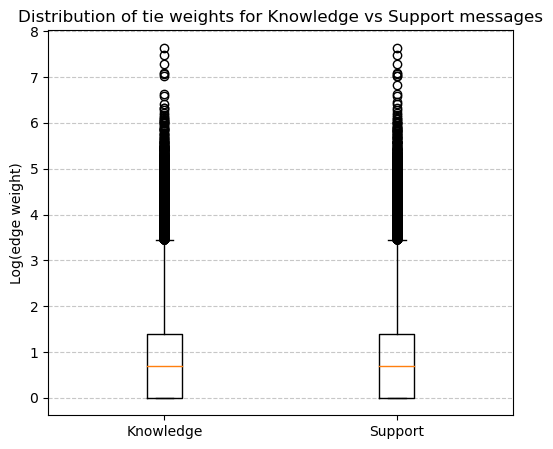

In [14]:
tie_df_undir = (
    dim_df.assign(user1=lambda x: x[['author','dest_author']].min(axis=1),
                  user2=lambda x: x[['author','dest_author']].max(axis=1))
          .groupby(['user1','user2'])
          .agg({
              'support_binary_adaptive_0.99': 'sum',
              'knowledge_binary_adaptive_0.99': 'sum'
          })
          .reset_index()
)
tie_df_undir['weight'] = (
    dim_df.assign(user1=lambda x: x[['author','dest_author']].min(axis=1),
                  user2=lambda x: x[['author','dest_author']].max(axis=1))
          .groupby(['user1','user2'])
          .size()
          .values
)

# Ties with at least one support or knowledge message (UNDIRECTED)
support_ties_undir = tie_df_undir[tie_df_undir['support_binary_adaptive_0.99'] > 0]['weight']
knowledge_ties_undir = tie_df_undir[tie_df_undir['knowledge_binary_adaptive_0.99'] > 0]['weight']

knowledge_ties_log = np.log(knowledge_ties_undir)
support_ties_log = np.log(support_ties_undir)

plt.figure(figsize=(6, 5))
plt.boxplot(
    [knowledge_ties_log, support_ties_log],
    labels=['Knowledge', 'Support'],
    #showfliers=False,  # optional: hide outliers for clarity
)
#plt.yscale('log')
plt.ylabel('Log(edge weight)')
plt.title('Distribution of tie weights for Knowledge vs Support messages')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

## ok!

## Right side figure 1

### Compute the bins

In [15]:
# distances = np.array([data["distance_km"] for u, v, data in G.edges(data=True)])
# bins = np.quantile(distances, [0, 0.2, 0.4, 0.6, 0.8, 1])

# print("Distance bins based on full graph:", bins)

In [16]:
# Social ties

# Create canonical pair order (sorted tuples)
dim_df["pair"] = dim_df.apply(
    lambda x: tuple(sorted([x["author"], x["dest_author"]])),
    axis=1
)

# Drop duplicates so each pair appears only once
unique_pairs = dim_df.drop_duplicates(subset="pair")
bins = unique_pairs["distance_km"].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
print("Bins based on unique undirected author pairs:", bins)

Bins based on unique undirected author pairs: [   0.           88.8327645  1059.01358728 1807.74910087 2762.7408041
 8163.84245135]


#### From graph to edges

In [17]:
# Full communication graph G

# def edges_to_df(G):
#     return pd.DataFrame([
#         (u, v, data["weight"], data["distance_km"])
#         for u, v, data in G.edges(data=True)
#     ], columns=["author", "dest_author", "weight", "distance_km"])
def edges_to_df(G):
    return pd.DataFrame([
        (
            u,
            v,
            G.nodes[u].get("state_code"),
            G.nodes[v].get("state_code"),
            data.get("weight"),
            data.get("distance_km")
        )
        for u, v, data in G.edges(data=True)
    ], columns=["author", "dest_author", "author_state_code", "dest_state_code", "weight", "distance_km"])

full_edges_df = edges_to_df(G)
full_edges_df["distance_bin"] = pd.cut(full_edges_df["distance_km"], bins=bins, include_lowest=True)

bin_medians = full_edges_df.groupby("distance_bin")["distance_km"].median()
print(bin_medians)

full_edges_df["distance_bin_label"] = full_edges_df["distance_bin"].map(bin_medians)
full_edges_df.head(2)

distance_bin
(-0.001, 88.833]           0.000000
(88.833, 1059.014]       712.552577
(1059.014, 1807.749]    1374.476493
(1807.749, 2762.741]    2263.175472
(2762.741, 8163.842]    3619.672763
Name: distance_km, dtype: float64


/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_54759/3277200246.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_medians = full_edges_df.groupby("distance_bin")["distance_km"].median()


,author,dest_author,author_state_code,dest_state_code,weight,distance_km,distance_bin,distance_bin_label
0,everydaygaming,everydaygaming,NJ,NJ,8,0.0,"(-0.001, 88.833]",0.0
1,mrslinkerton,mrslinkerton,IA,IA,7,0.0,"(-0.001, 88.833]",0.0


In [18]:
len(full_edges_df)

277204

In [19]:
# Dimension-specific 

def dimension_edges_df(Gd, bins):
    df = edges_to_df(Gd)
    df["distance_bin"] = pd.cut(df["distance_km"], bins=bins, include_lowest=True)
    return df

support_edges_df = dimension_edges_df(graphs['support'], bins)
knowledge_edges_df = dimension_edges_df(graphs['knowledge'], bins)

In [20]:
len(support_edges_df)/len(full_edges_df)

0.5638446775659803

In [21]:
support_edges_df.head(2)

,author,dest_author,author_state_code,dest_state_code,weight,distance_km,distance_bin
0,daram4u,dv8r,MA,NY,1,251.514483,"(88.833, 1059.014]"
1,everydaygaming,peaceloveandbacon,NJ,MO,1,1521.005496,"(1059.014, 1807.749]"


In [22]:
full_edges_df.head(2)

,author,dest_author,author_state_code,dest_state_code,weight,distance_km,distance_bin,distance_bin_label
0,everydaygaming,everydaygaming,NJ,NJ,8,0.0,"(-0.001, 88.833]",0.0
1,mrslinkerton,mrslinkerton,IA,IA,7,0.0,"(-0.001, 88.833]",0.0


### Compute $p(d|l)$

In [23]:
def compute_p_dl(full_edges_df, dim_edges_df):
    total_per_bin = full_edges_df.groupby("distance_bin").size()
    dim_per_bin = dim_edges_df.groupby("distance_bin").size()

    p_dl = (dim_per_bin / total_per_bin)#.fillna(0)
    return p_dl

p_support = compute_p_dl(full_edges_df, support_edges_df)
p_knowledge = compute_p_dl(full_edges_df, knowledge_edges_df)

print("p(d|l) for support dimension:\n", p_support)
print("p(d|l) for knowledge dimension:\n", p_knowledge)


p(d|l) for support dimension:
 distance_bin
(-0.001, 88.833]        0.358718
(88.833, 1059.014]      0.693504
(1059.014, 1807.749]    0.707503
(1807.749, 2762.741]    0.715102
(2762.741, 8163.842]    0.725144
dtype: float64
p(d|l) for knowledge dimension:
 distance_bin
(-0.001, 88.833]        0.319488
(88.833, 1059.014]      0.689976
(1059.014, 1807.749]    0.718407
(1807.749, 2762.741]    0.743327
(2762.741, 8163.842]    0.781671
dtype: float64


/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_54759/1146646729.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_bin = full_edges_df.groupby("distance_bin").size()
/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_54759/1146646729.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dim_per_bin = dim_edges_df.groupby("distance_bin").size()
/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_54759/1146646729.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beh

### Null model

In [24]:
# Distance lookup table

import itertools

def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius (km)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

state_pairs = list(itertools.product(coords.index, coords.index))
distances = {}

for s1, s2 in state_pairs:
    lat1, lon1 = coords.loc[s1]
    lat2, lon2 = coords.loc[s2]
    distances[(s1, s2)] = haversine_np(lat1, lon1, lat2, lon2)

dist_series = pd.Series(distances)

In [29]:
def p_null(n_iter, edge_df, bins, full_edges_df):

    p_null = []
    for i in range(n_iter):

        shuffled = edge_df.copy()
        shuffled["author_state_code"] = np.random.permutation(shuffled["author_state_code"].values)
        shuffled["dest_state_code"] = np.random.permutation(shuffled["dest_state_code"].values)

        shuffled['distance_km'] = shuffled.apply(
            lambda x: dist_series.get((x['author_state_code'], x['dest_state_code']), np.nan),
            axis=1
        )

        shuffled['distance_bin'] = pd.cut(
            shuffled['distance_km'],
            bins=bins,
            include_lowest=True
        )
        
        p_null.append(compute_p_dl(full_edges_df, shuffled))

    p_null_df = pd.concat(p_null, axis=1)
    p_null_df.columns = [f"iter_{i}" for i in range(n_iter)]

    p_null_mean = p_null_df.mean(axis=1)
    p_null_lower = p_null_df.quantile(0.025, axis=1)
    p_null_upper = p_null_df.quantile(0.975, axis=1)

    return pd.DataFrame({
        "p_null_mean": p_null_mean,
        "p_null_lower": p_null_lower,
        "p_null_upper": p_null_upper
    })
        

In [ ]:
# SUPPORT 

p_support_null = p_null(n_iter=50, edge_df=support_edges_df, bins=bins,full_edges_df=full_edges_df)
p_support_null

In [31]:
p_support_null = p_support_null.reindex(p_support.index)

p_support_summary = pd.concat([
    p_support.rename("p_real"),
    p_support_null
], axis=1)

p_support_summary["delta_p"] = p_support_summary["p_real"] / p_support_summary["p_null_mean"] - 1
p_support_summary["delta_p_percent"] = p_support_summary["delta_p"] * 100
p_support_summary

,p_real,p_null_mean,p_null_lower,p_null_upper,delta_p,delta_p_percent
distance_bin,,,,,,
"(-0.001, 88.833]",0.358718,0.063575,0.062322,0.064620,4.642469,464.246907
"(88.833, 1059.014]",0.693504,0.856376,0.849195,0.862725,-0.190187,-19.018739
"(1059.014, 1807.749]",0.707503,0.918720,0.912811,0.924623,-0.229904,-22.990404
"(1807.749, 2762.741]",0.715102,0.944280,0.937425,0.950261,-0.242702,-24.270159
"(2762.741, 8163.842]",0.725144,0.965771,0.960406,0.974324,-0.249155,-24.915518


In [ ]:
# KNOWLEDGE

p_knowledge_null = p_null(n_iter=50, edge_df=knowledge_edges_df, bins=bins,full_edges_df=full_edges_df)


In [33]:
p_kmowledge_null = p_knowledge_null.reindex(p_knowledge.index)

p_knowledge_summary = pd.concat([
    p_knowledge.rename("p_real"),
    p_knowledge_null
], axis=1)

p_knowledge_summary["delta_p"] = p_knowledge_summary["p_real"] / p_knowledge_summary["p_null_mean"] - 1
p_knowledge_summary["delta_p_percent"] = p_knowledge_summary["delta_p"] * 100
p_knowledge_summary

,p_real,p_null_mean,p_null_lower,p_null_upper,delta_p,delta_p_percent
distance_bin,,,,,,
"(-0.001, 88.833]",0.319488,0.068881,0.067702,0.070459,3.638263,363.826306
"(88.833, 1059.014]",0.689976,0.816510,0.810751,0.821986,-0.154970,-15.497007
"(1059.014, 1807.749]",0.718407,0.886119,0.879757,0.893659,-0.189266,-18.926607
"(1807.749, 2762.741]",0.743327,0.942683,0.937356,0.947740,-0.211478,-21.147752
"(2762.741, 8163.842]",0.781671,1.005932,0.997494,1.011396,-0.222938,-22.293808


_______________

## What if we treat as undirected / and full graph (not >= 4 messages to be considered a tie)

In [34]:
dim_df.head(2)

,author,time,dest_author,author_state_code,dest_state_code,support_binary_adaptive_0.5,knowledge_binary_adaptive_0.5,conflict_binary_adaptive_0.5,power_binary_adaptive_0.5,similarity_binary_adaptive_0.5,...,status_binary_adaptive_0.99,trust_binary_adaptive_0.99,identity_binary_adaptive_0.99,romance_binary_adaptive_0.99,latitude_a,longitude_a,latitude_b,longitude_b,distance_km,pair
0,allurex,1.352921e+09,allurex,MO,MO,0,1,0,0,0,...,0,0,0,0,37.964253,-91.831833,37.964253,-91.831833,0.000000,"(allurex, allurex)"
1,dtrmp4,1.352929e+09,allurex,MI,MO,1,0,0,1,1,...,0,0,0,0,44.314844,-85.602364,37.964253,-91.831833,877.357917,"(allurex, dtrmp4)"


In [37]:
full_social_ties = (
    dim_df.assign(
        author_min=lambda x: x[['author', 'dest_author']].min(axis=1),
        author_max=lambda x: x[['author', 'dest_author']].max(axis=1),
        state_min=lambda x: x[['author_state_code', 'dest_state_code']].min(axis=1),
        state_max=lambda x: x[['author_state_code', 'dest_state_code']].max(axis=1)
    )
    .groupby(['author_min', 'author_max', 'state_min', 'state_max'])
    .agg(
        weight=('author', 'size'),  # total messages
        support_messages=('support_binary_adaptive_0.99', 'sum'),
        knowledge_messages=('knowledge_binary_adaptive_0.99', 'sum'),
        distance_km=('distance_km', 'first')
    )
    .reset_index()
    .rename(columns={
        'author_min': 'author',
        'author_max': 'dest_author',
        'state_min': 'author_state_code',
        'state_max': 'dest_state_code'
    })
)

In [43]:
quintile_edges = full_social_ties['distance_km'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]).values

full_social_ties['distance_quintile'] = pd.cut(
    full_social_ties['distance_km'],
    bins=quintile_edges,
    labels=False, 
    include_lowest=True
)

bin_medians = []
for i in range(5):
    bin_mask = (full_social_ties['distance_km'] >= quintile_edges[i]) & (full_social_ties['distance_km'] <= quintile_edges[i+1])
    median_val = full_social_ties.loc[bin_mask, 'distance_km'].median()
    bin_medians.append(median_val)

full_social_ties['distance_median_bin'] = full_social_ties['distance_quintile'].map(lambda x: bin_medians[int(x)])


In [44]:
unique_medians = full_social_ties['distance_median_bin'].unique()
print(unique_medians)

[1371.9660328   728.62322405 3611.9998841  2263.17547235    0.        ]


In [45]:
support_ties = full_social_ties[full_social_ties['support_messages'] > 0]
knowledge_ties = full_social_ties[full_social_ties['knowledge_messages'] > 0]

In [50]:
support_ties.head(2)

,author,dest_author,author_state_code,dest_state_code,weight,support_messages,knowledge_messages,distance_km,distance_quintile,distance_median_bin
14,-----imartijn-----,arrkon,NC,WA,2,1,0,3656.052224,4,3611.999884
178,---justme---,_novi_,TX,TX,3,1,0,0.000000,0,0.000000


### Compute $p(d|l)$

In [51]:
def compute_p_dl(full_edges_df, dim_edges_df):
    total_per_bin = full_edges_df.groupby("distance_median_bin").size()
    dim_per_bin = dim_edges_df.groupby("distance_median_bin").size()

    p_dl = (dim_per_bin / total_per_bin)
    return p_dl

In [52]:
p_support = compute_p_dl(full_social_ties, support_ties)
p_knowledge = compute_p_dl(full_social_ties, knowledge_ties)

In [53]:
print(p_support)
print(p_knowledge)

distance_median_bin
0.000000       0.019060
728.623224     0.013024
1371.966033    0.013034
2263.175472    0.013064
3611.999884    0.012929
dtype: float64
distance_median_bin
0.000000       0.017289
728.623224     0.013433
1371.966033    0.013710
2263.175472    0.014023
3611.999884    0.014382
dtype: float64


### Null model

In [56]:
def p_null(n_iter, dim_ties, bins, full_ties):

    p_null = []
    for i in range(n_iter):

        shuffled = dim_ties.copy()
        shuffled["author_state_code"] = np.random.permutation(shuffled["author_state_code"].values)
        shuffled["dest_state_code"] = np.random.permutation(shuffled["dest_state_code"].values)

        shuffled['distance_km'] = shuffled.apply(
            lambda x: dist_series.get((x['author_state_code'], x['dest_state_code']), np.nan),
            axis=1
        )

        shuffled['distance_quintile'] = pd.cut(
            shuffled['distance_km'],
            bins=bins,
            labels=False,
            include_lowest=True
        )
        shuffled['distance_median_bin'] = shuffled['distance_quintile'].map(lambda x: bin_medians[int(x)])

        p_null.append(compute_p_dl(full_ties, shuffled))

    p_null_df = pd.concat(p_null, axis=1)
    p_null_df.columns = [f"iter_{i}" for i in range(n_iter)]

    p_null_mean = p_null_df.mean(axis=1)
    p_null_lower = p_null_df.quantile(0.025, axis=1)
    p_null_upper = p_null_df.quantile(0.975, axis=1)

    return pd.DataFrame({
        "p_null_mean": p_null_mean,
        "p_null_lower": p_null_lower,
        "p_null_upper": p_null_upper
    })
        

In [57]:
p_support_ties_null = p_null(n_iter=3, dim_ties=support_ties,bins=quintile_edges, full_ties=full_social_ties)
print(p_support_ties_null)

                     p_null_mean  p_null_lower  p_null_upper
distance_median_bin                                         
0.000000                0.002520      0.002500      0.002534
728.623224              0.016253      0.016216      0.016289
1371.966033             0.017588      0.017497      0.017663
2263.175472             0.017532      0.017474      0.017635
3611.999884             0.017248      0.017217      0.017266


In [58]:
# Summary

p_support_ties_null = p_support_ties_null.reindex(p_support.index)

p_support_summary = pd.concat([
    p_support.rename("p_real"),
    p_support_ties_null
], axis=1)

p_support_summary["delta_p"] = p_support_summary["p_real"] / p_support_summary["p_null_mean"] - 1
p_support_summary["delta_p_percent"] = p_support_summary["delta_p"] * 100

In [59]:
print(p_support_summary)

                       p_real  p_null_mean  p_null_lower  p_null_upper  \
distance_median_bin                                                      
0.000000             0.019060     0.002520      0.002500      0.002534   
728.623224           0.013024     0.016253      0.016216      0.016289   
1371.966033          0.013034     0.017588      0.017497      0.017663   
2263.175472          0.013064     0.017532      0.017474      0.017635   
3611.999884          0.012929     0.017248      0.017217      0.017266   

                      delta_p  delta_p_percent  
distance_median_bin                             
0.000000             6.563391       656.339089  
728.623224          -0.198649       -19.864852  
1371.966033         -0.258931       -25.893075  
2263.175472         -0.254859       -25.485910  
3611.999884         -0.250409       -25.040861  


### Another way to shuffle

In [60]:
authors_df = dim_df[['author', 'author_state_code']].rename(columns={'author':'user', 'author_state_code':'state_code'})
dests_df = dim_df[['dest_author', 'dest_state_code']].rename(columns={'dest_author':'user', 'dest_state_code':'state_code'})
users_df = pd.concat([authors_df, dests_df]).drop_duplicates().reset_index(drop=True)


In [71]:
def p_null_userlevel(n_iter, dim_ties, bins, full_ties):
    p_null_list = []

    for i in range(n_iter):
        # 1️⃣ Shuffle state codes at the user level
        shuffled_states = users_df["state_code"].sample(frac=1, replace=False).reset_index(drop=True)
        users_shuffled = users_df.copy()
        users_shuffled["shuffled_state"] = shuffled_states

        # 2️⃣ Create mapping dictionaries
        user_to_shuffled_state = users_shuffled.set_index("user")["shuffled_state"].to_dict()

        # 3️⃣ Assign shuffled states to author and destination
        shuffled = dim_ties.copy()
        shuffled['author_state_code'] = shuffled['author'].map(user_to_shuffled_state)
        shuffled['dest_state_code'] = shuffled['dest_author'].map(user_to_shuffled_state)

        # 4️⃣ Recompute distances based on shuffled states
        shuffled['distance_km'] = shuffled.apply(
            lambda x: dist_series.get((x['author_state_code'], x['dest_state_code']), np.nan),
            axis=1
        )

        # 5️⃣ Assign distance quintiles and median labels
        shuffled['distance_quintile'] = pd.cut(
            shuffled['distance_km'],
            bins=bins,
            labels=False,
            include_lowest=True
        )
        shuffled['distance_median_bin'] = shuffled['distance_quintile'].map(lambda x: bin_medians[int(x)])

        # 6️⃣ Compute p(d|l) for this iteration
        p_null_list.append(compute_p_dl(full_ties, shuffled))

    # Combine iterations
    p_null_df = pd.concat(p_null_list, axis=1)
    p_null_df.columns = [f"iter_{i}" for i in range(n_iter)]

    # Summary statistics
    p_null_mean = p_null_df.mean(axis=1)
    p_null_lower = p_null_df.quantile(0.025, axis=1)
    p_null_upper = p_null_df.quantile(0.975, axis=1)

    return pd.DataFrame({
        "p_null_mean": p_null_mean,
        "p_null_lower": p_null_lower,
        "p_null_upper": p_null_upper
    })


In [75]:
p_support_null_last = p_null_userlevel(n_iter=50, dim_ties=support_ties,bins=quintile_edges, full_ties=full_social_ties)
print(p_support_null_last)

                     p_null_mean  p_null_lower  p_null_upper
distance_median_bin                                         
0.000000                0.008237      0.008165      0.008319
728.623224              0.015537      0.015387      0.015712
1371.966033             0.016228      0.016066      0.016408
2263.175472             0.015925      0.015723      0.016125
3611.999884             0.015191      0.015025      0.015469


In [76]:
# Summary
p_support_null_last = p_support_null_last.reindex(p_support.index)

p_support_summary = pd.concat([
    p_support.rename("p_real"),
    p_support_null_last
], axis=1)

p_support_summary["delta_p"] = p_support_summary["p_real"] / p_support_summary["p_null_mean"] - 1
p_support_summary["delta_p_percent"] = p_support_summary["delta_p"] * 100

In [77]:
print(p_support_summary)

                       p_real  p_null_mean  p_null_lower  p_null_upper  \
distance_median_bin                                                      
0.000000             0.019060     0.008237      0.008165      0.008319   
728.623224           0.013024     0.015537      0.015387      0.015712   
1371.966033          0.013034     0.016228      0.016066      0.016408   
2263.175472          0.013064     0.015925      0.015723      0.016125   
3611.999884          0.012929     0.015191      0.015025      0.015469   

                      delta_p  delta_p_percent  
distance_median_bin                             
0.000000             1.313898       131.389803  
728.623224          -0.161731       -16.173077  
1371.966033         -0.196856       -19.685645  
2263.175472         -0.179670       -17.967039  
3611.999884         -0.148917       -14.891656  


In [78]:
# KNOWLEDGE

p_knowledge_null_last = p_null_userlevel(n_iter=50, dim_ties=knowledge_ties,bins=quintile_edges, full_ties=full_social_ties)
print(p_knowledge_null_last)

                     p_null_mean  p_null_lower  p_null_upper
distance_median_bin                                         
0.000000                0.007789      0.007718      0.007864
728.623224              0.016063      0.015889      0.016238
1371.966033             0.016793      0.016643      0.016989
2263.175472             0.016492      0.016222      0.016738
3611.999884             0.015692      0.015448      0.015952


In [79]:
# Summary
p_knowledge_null_last = p_knowledge_null_last.reindex(p_knowledge.index)

p_knowledge_summary = pd.concat([
    p_knowledge.rename("p_real"),
    p_knowledge_null_last
], axis=1)

p_knowledge_summary["delta_p"] = p_knowledge_summary["p_real"] / p_knowledge_summary["p_null_mean"] - 1
p_knowledge_summary["delta_p_percent"] = p_knowledge_summary["delta_p"] * 100
print(p_knowledge_summary)

                       p_real  p_null_mean  p_null_lower  p_null_upper  \
distance_median_bin                                                      
0.000000             0.017289     0.007789      0.007718      0.007864   
728.623224           0.013433     0.016063      0.015889      0.016238   
1371.966033          0.013710     0.016793      0.016643      0.016989   
2263.175472          0.014023     0.016492      0.016222      0.016738   
3611.999884          0.014382     0.015692      0.015448      0.015952   

                      delta_p  delta_p_percent  
distance_median_bin                             
0.000000             1.219495       121.949460  
728.623224          -0.163755       -16.375523  
1371.966033         -0.183592       -18.359207  
2263.175472         -0.149688       -14.968761  
3611.999884         -0.083490        -8.349031  


### Message-level meassurement

_____________